# Metadata

```
Course: DS 5001
Semester Project
Topic: Gilmore Girls
Author: Alice Bogdan
Computing id: ucn3qn
```

Purpose: Using ETA on Gilmore Girls tv scripts. Preprocess the data

In [ ]:
# import requests
# from lxml import etree
# import pandas as pd
# import numpy as np
# from io import StringIO
# from glob import glob
# import re

# series_id = 22
# outdir = './dump'
# base_url = "https://transcripts.foreverdreaming.org"

# parser = etree.HTMLParser()

# def get_pages(series_id, offset=0, outdir=''):
#     src_url = f"{base_url}/viewforum.php?f={series_id}&start={offset}"
#     r = requests.get(src_url)
#     tree = etree.parse(StringIO(r.text), parser)
#     page_urls = [f"{base_url}/{path[2:]}" for path in tree.xpath('//a[@class="topictitle"]/@href')]
#     for page_url in page_urls:
#         f, t, sid = page_url.split('?')[-1].split('&')
#         page_r = requests.get(page_url)
#         out_file_name = f"f{f.split('=')[-1]}-r{t.split('=')[-1]}.html"
#         with open(f"{outdir}/{out_file_name}", 'w') as out:
#             out.write(page_r.text)

# for offset in range(0, 175, 25):
#     print(offset)
#     get_pages(22, offset, outdir)

# xpaths = {
#        'title': "//div[@class='boxheading']/h2/text()",
#         'time': "//time/@datetime",
#         'content': "//div[@class='postbody']/p/text()"
# }

# data = []
# for page in glob(f"{outdir}/*.html"):
#     tree = etree.parse(page, parser)
#     title = tree.xpath(xpaths['title'])[0]
#     time = tree.xpath(xpaths['time'])[0]
#     lines = tree.xpath(xpaths['content'])    
#     for i, line in enumerate(lines):
#         data.append((title, time, i, line))
# df = pd.DataFrame(data, columns=['title_raw','time_raw','line_num','doc_raw'])

# df.to_csv(f'{data_home}/output/{data_prefix}.csv')

# Set Up

In [1]:
#libraries
import pandas as pd
import numpy as np
import nltk
# from sklearn.decomposition import PCA
from scipy.linalg import norm
import plotly.express as px
import seaborn as sns; sns.set()
import re

In [2]:
#nltk.download('stopwords')

In [3]:
import os
import sys

# Outputs from this Notebook

In [4]:
data_home = "data"
data_prefix = 'Gilmore_Girls'

In [5]:
# DATA = pd.read_csv(f"{data_home}/output/{data_prefix}-DATA.csv")
# CORPUS = pd.read_csv(f"{data_home}/output/{data_prefix}-TOKENS.csv") #aka the CORPUS
# VOCAB = pd.read_csv(f"{data_home}/output/{data_prefix}-VOCAB.csv")

# Load Data

In [6]:
#import data
DATA = pd.read_csv(f"{data_home}/output/{data_prefix}.csv")

In [7]:
#split title_raw into three columns: Season, Episode, and Title
DATA[['Season', 'Title']] = DATA['title_raw'].str.split('-', n = 1, expand = True)
DATA[['Season', 'Episode']] = DATA['Season'].str.split('x', n = 1, expand = True)

In [8]:
#remove whitespace
DATA['Episode'] = DATA['Episode'].str.strip()
DATA['Season'] = DATA['Season'].str.strip()

In [9]:
#subset data to remove Unamed: 0 and title_raw
DATA = DATA[["Season", "Episode", "Title","time_raw","line_num","doc_raw"]]

need to:
cut by scene
get rid of anything in [] or ()
capture names starts with all caps followed : 

In [10]:
#keep only seasons 1-7 (season 8 is an exception)
DATA = DATA[DATA['Season'].isin(['01', '02', '03', '04', '05', '06', '07'])]
DATA = DATA.sort_values(['Season', 'Episode'])

In [11]:
#not every episode has scenes
DATA[DATA['doc_raw'].str.contains("cut to", case = False)][0:25]

,Season,Episode,Title,time_raw,line_num,doc_raw
61833,01,01,The Pilot,2000-10-17T15:42:16Z,80,CUT TO THE INDEPENDENCE INN
61878,01,01,The Pilot,2000-10-17T15:42:16Z,125,CUT TO OUTSIDE
61897,01,01,The Pilot,2000-10-17T15:42:16Z,144,CUT TO CLASSROOM
61906,01,01,The Pilot,2000-10-17T15:42:16Z,153,CUT TO THE INDEPENDENCE INN
61943,01,01,The Pilot,2000-10-17T15:42:16Z,190,CUT TO OUTSIDE
61999,01,01,The Pilot,2000-10-17T15:42:16Z,246,CUT TO INDEPENDENCE INN KITCHEN
62059,01,01,The Pilot,2000-10-17T15:42:16Z,306,CUT TO INDEPENDENCE INN LOBBY
62069,01,01,The Pilot,2000-10-17T15:42:16Z,316,CUT TO LORELAI'S HOUSE
62072,01,01,The Pilot,2000-10-17T15:42:16Z,319,CUT TO LORELAI'S FRONT PORCH
62121,01,01,The Pilot,2000-10-17T15:42:16Z,368,CUT TO ELDER GILMORE RESIDENCE


# Preprocessing

Output data has been saved and can be uploaded

## Remove stage directions

In [12]:
#regex to capture lines beginning and ending with [] or () indicating stage directions
stage_dir = r"(\(.*\))|(\[.*\])"

In [13]:
#COPY = DATA.copy()

In [14]:
#run regex code to find lines with stage directions
stage_lines = DATA.doc_raw.str.match(stage_dir, case=False) # Returns a truth vector

In [15]:
#remove stage direction lines
DATA = DATA.loc[-stage_lines]

In [16]:
#remove stage directions found within lines
DATA['doc_raw'] = DATA['doc_raw'].replace(regex = stage_dir, value='')

In [17]:
DATA

,Season,Episode,Title,time_raw,line_num,doc_raw
61753,01,01,The Pilot,2000-10-17T15:42:16Z,0,1.01 - Pilot
61754,01,01,The Pilot,2000-10-17T15:42:16Z,1,written by Amy Sherman-Palladino
61755,01,01,The Pilot,2000-10-17T15:42:16Z,2,directed by Lesli Linka Glatter
61756,01,01,The Pilot,2000-10-17T15:42:16Z,3,OPEN IN STARS HOLLOW
61758,01,01,The Pilot,2000-10-17T15:42:16Z,5,"LORELAI: Please, Luke. Please, please, please."
...,...,...,...,...,...,...
100866,07,22,Bon Voyage,2007-05-27T10:54:44Z,808,LORELAI: Well how will people know you're the ...
100867,07,22,Bon Voyage,2007-05-27T10:54:44Z,809,RORY: I don't know.
100868,07,22,Bon Voyage,2007-05-27T10:54:44Z,810,LORELAI: I guess they'll just have to read you...
100869,07,22,Bon Voyage,2007-05-27T10:54:44Z,811,RORY: I guess so.


## Capture Characters

In [18]:
#regex to capture characters (example, "RORY:"")
char_pat = r"^[A-Z]* ?:"

In [19]:
#find all lines that begin with character talking
char_lines = DATA.doc_raw.str.match(char_pat, case=False) # Returns a truth vector

In [20]:
#filter data for only lines where characters talk
#this also removes fluff lines such as the director, episode number, "OPEN IN", "THE END", etc
DATA = DATA.loc[char_lines]

In [21]:
DATA

,Season,Episode,Title,time_raw,line_num,doc_raw
61758,01,01,The Pilot,2000-10-17T15:42:16Z,5,"LORELAI: Please, Luke. Please, please, please."
61759,01,01,The Pilot,2000-10-17T15:42:16Z,6,LUKE: How many cups have you had this morning?
61760,01,01,The Pilot,2000-10-17T15:42:16Z,7,LORELAI: None.
61761,01,01,The Pilot,2000-10-17T15:42:16Z,8,LUKE: Plus...
61762,01,01,The Pilot,2000-10-17T15:42:16Z,9,"LORELAI: Five, but yours is better."
...,...,...,...,...,...,...
100865,07,22,Bon Voyage,2007-05-27T10:54:44Z,807,RORY: Well It wasn't very flattering.
100866,07,22,Bon Voyage,2007-05-27T10:54:44Z,808,LORELAI: Well how will people know you're the ...
100867,07,22,Bon Voyage,2007-05-27T10:54:44Z,809,RORY: I don't know.
100868,07,22,Bon Voyage,2007-05-27T10:54:44Z,810,LORELAI: I guess they'll just have to read you...


## Split doc_raw to form column for characters

In [22]:
DATA[['Character', 'Lines']] = DATA['doc_raw'].str.split(':', n = 1, expand = True)

/Users/alicebogdan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [24]:
DATA = DATA[["Season","Episode","Title","time_raw","line_num","Character","Lines"]]

In [25]:
DATA

,Season,Episode,Title,time_raw,line_num,Character,Lines
61758,01,01,The Pilot,2000-10-17T15:42:16Z,5,LORELAI,"Please, Luke. Please, please, please."
61759,01,01,The Pilot,2000-10-17T15:42:16Z,6,LUKE,How many cups have you had this morning?
61760,01,01,The Pilot,2000-10-17T15:42:16Z,7,LORELAI,None.
61761,01,01,The Pilot,2000-10-17T15:42:16Z,8,LUKE,Plus...
61762,01,01,The Pilot,2000-10-17T15:42:16Z,9,LORELAI,"Five, but yours is better."
...,...,...,...,...,...,...,...
100865,07,22,Bon Voyage,2007-05-27T10:54:44Z,807,RORY,Well It wasn't very flattering.
100866,07,22,Bon Voyage,2007-05-27T10:54:44Z,808,LORELAI,Well how will people know you're the world's ...
100867,07,22,Bon Voyage,2007-05-27T10:54:44Z,809,RORY,I don't know.
100868,07,22,Bon Voyage,2007-05-27T10:54:44Z,810,LORELAI,I guess they'll just have to read your stuff.


In [26]:
DATA['Character'] = DATA['Character'].str.strip()
DATA['Character'] = DATA['Character'].str.upper()

<ipython-input-26-d8d10a87a192>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DATA['Character'] = DATA['Character'].str.strip()
<ipython-input-26-d8d10a87a192>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DATA['Character'] = DATA['Character'].str.upper()


In [27]:
DATA['Character'].sort_values().unique()

array(['', 'ADVISOR', 'AK', 'ALAN', 'ALEX', 'ALEXANDRA', 'ALISON', 'ALL',
       'ALTHEA', 'AMIR', 'ANDRE', 'ANDREA', 'ANDREW', 'ANDY', 'ANN',
       'ANNA', 'ANNABELLE', 'ANNOUNCER', 'ANTONIA', 'APRIL', 'ARLETTA',
       'ARTHUR', 'ASHER', 'ATTENDANT', 'AUBREY', 'AUCTIONEER', 'AUDREY',
       'AURORA', 'AVA', 'AYOR', 'BABETE', 'BABETTE', 'BAND', 'BARBARA',
       'BARBETTE', 'BARRY', 'BARTENDER', 'BEATRICE', 'BEAU', 'BELLBOY',
       'BEN', 'BENNY', 'BERT', 'BEVERLY', 'BIKER', 'BIKERS', 'BILL',
       'BILLY', 'BOB', 'BOBBI', 'BOBBY', 'BONNIE', 'BOOTSY', 'BOOZOO',
       'BOTH', 'BOUNCER', 'BOY', 'BOYS', 'BRAD', 'BRADLEY', 'BRAIN',
       'BRANDON', 'BRENNON', 'BRIAN', 'BRIDE', 'BRUCE', 'BRUNETTE',
       'BUDDY', 'BUTCHER', 'CAESAR', 'CAESER', 'CAITLYN', 'CARL', 'CAROL',
       'CAROLE', 'CAROLINE', 'CAROLYN', 'CARRIE', 'CASHIER', 'CATHERINE',
       'CELINE', 'CHAD', 'CHARLENE', 'CHARLESTON', 'CHARLIE', 'CHARLOTTE',
       'CHASE', 'CHEF', 'CHERRY', 'CHERYL', 'CHESTER', 'CHILDREN', 

In [28]:
#it's Rory
DATA[DATA['Character'] == ""]

,Season,Episode,Title,time_raw,line_num,Character,Lines
17465,01,20,P.S. I Lo...,2001-05-15T14:32:16Z,782,,Please.


In [29]:
DATA['Episode'].unique()

array(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22'],
      dtype=object)

In [30]:
#incorrect names lists
lorelai_sp = ['LOREAI', 'LOREALI', 'LORELA', 'LORELAIL', 'LORELI', 'LORLAI', 'LORLEAI', 'LORLELAI', 'L','ORELAI']
luke_sp = ['LUK']
rory_sp = ['R',"",'ORY']
richard_sp = ['RICHRAD','GRANDPA']
emily_sp = ['EMIL','GRANDMOTHER','GRANDMA','RMILY']
sookie_sp = ['SOOKEI', 'SOOKI', 'SOOKIES']
caesar_sp = ['CAESER']
christopher_sp = ['CHRISTOHPER','CHRISTOPER','CHRSTOPHER','CHRISTOPER','CHRIS']
lindsay_sp = ['LINDAY'] #dean's wife
headmaster_sp = ['CHARLESTON']
babette_sp = ['BABETE','BARBETTE']
logan_sp = ['LOG']
trix_sp = ['GRAN'] #Lorelai the first
michel_sp = ['MICHE','MICHELL']
tristin_sp = ['TRISTAN']
troubadour_sp = ['TROUBADOR']
tanna_sp = ['TANA'] #Rory's college roommate
prof_sp = ['PROFERSSOR']
brian_sp = ['BRAIN'] #band member
taylor_sp = ['TAYOR']

In [31]:
#replace incorrect names with correct names
DATA['Character'] = DATA['Character'].replace(lorelai_sp, value = 'LORELAI')
DATA['Character'] = DATA['Character'].replace(luke_sp, value = 'LUKE')
DATA['Character'] = DATA['Character'].replace(rory_sp, value = 'RORY')
DATA['Character'] = DATA['Character'].replace(richard_sp, value = 'RICHARD')
DATA['Character'] = DATA['Character'].replace(emily_sp, value = 'EMILY')
DATA['Character'] = DATA['Character'].replace(sookie_sp, value = 'SOOKIE')
DATA['Character'] = DATA['Character'].replace(caesar_sp, value = 'CAESAR')
DATA['Character'] = DATA['Character'].replace(christopher_sp, value = 'CHRISTOPHER')
DATA['Character'] = DATA['Character'].replace(lindsay_sp, value = 'LINDSAY')
DATA['Character'] = DATA['Character'].replace(headmaster_sp, value = 'HEADMASTER')
DATA['Character'] = DATA['Character'].replace(babette_sp, value = 'BABETTE')
DATA['Character'] = DATA['Character'].replace(logan_sp, value = 'LOGAN')
DATA['Character'] = DATA['Character'].replace(trix_sp, value = 'TRIX')
DATA['Character'] = DATA['Character'].replace(michel_sp, value = 'MICHEL')
DATA['Character'] = DATA['Character'].replace(tristin_sp, value = 'TRISTIN')
DATA['Character'] = DATA['Character'].replace(troubadour_sp, value = 'TROUBADOUR')
DATA['Character'] = DATA['Character'].replace(tanna_sp, value = 'TANNA')
DATA['Character'] = DATA['Character'].replace(prof_sp, value = 'PROFESSOR')
DATA['Character'] = DATA['Character'].replace(brian_sp, value = 'BRIAN')
DATA['Character'] = DATA['Character'].replace(taylor_sp, value = 'TAYLOR')

<ipython-input-31-a20c201ba9c1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DATA['Character'] = DATA['Character'].replace(lorelai_sp, value = 'LORELAI')
<ipython-input-31-a20c201ba9c1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DATA['Character'] = DATA['Character'].replace(luke_sp, value = 'LUKE')
<ipython-input-31-a20c201ba9c1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [32]:
DATA['Character'].sort_values().unique()

array(['ADVISOR', 'AK', 'ALAN', 'ALEX', 'ALEXANDRA', 'ALISON', 'ALL',
       'ALTHEA', 'AMIR', 'ANDRE', 'ANDREA', 'ANDREW', 'ANDY', 'ANN',
       'ANNA', 'ANNABELLE', 'ANNOUNCER', 'ANTONIA', 'APRIL', 'ARLETTA',
       'ARTHUR', 'ASHER', 'ATTENDANT', 'AUBREY', 'AUCTIONEER', 'AUDREY',
       'AURORA', 'AVA', 'AYOR', 'BABETTE', 'BAND', 'BARBARA', 'BARRY',
       'BARTENDER', 'BEATRICE', 'BEAU', 'BELLBOY', 'BEN', 'BENNY', 'BERT',
       'BEVERLY', 'BIKER', 'BIKERS', 'BILL', 'BILLY', 'BOB', 'BOBBI',
       'BOBBY', 'BONNIE', 'BOOTSY', 'BOOZOO', 'BOTH', 'BOUNCER', 'BOY',
       'BOYS', 'BRAD', 'BRADLEY', 'BRANDON', 'BRENNON', 'BRIAN', 'BRIDE',
       'BRUCE', 'BRUNETTE', 'BUDDY', 'BUTCHER', 'CAESAR', 'CAITLYN',
       'CARL', 'CAROL', 'CAROLE', 'CAROLINE', 'CAROLYN', 'CARRIE',
       'CASHIER', 'CATHERINE', 'CELINE', 'CHAD', 'CHARLENE', 'CHARLIE',
       'CHARLOTTE', 'CHASE', 'CHEF', 'CHERRY', 'CHERYL', 'CHESTER',
       'CHILDREN', 'CHIP', 'CHRISSY', 'CHRISTINE', 'CHRISTOPHER',
       'CHRI

In [33]:
DATA[DATA['Character'] == 'TAYOR']

,Season,Episode,Title,time_raw,line_num,Character,Lines


In [34]:
#extract year
DATA['Year'] = DATA.time_raw.str.split('-', n = 1, expand = True)[0]

In [35]:
DATA

,Season,Episode,Title,time_raw,line_num,Character,Lines,Year
61758,01,01,The Pilot,2000-10-17T15:42:16Z,5,LORELAI,"Please, Luke. Please, please, please.",2000
61759,01,01,The Pilot,2000-10-17T15:42:16Z,6,LUKE,How many cups have you had this morning?,2000
61760,01,01,The Pilot,2000-10-17T15:42:16Z,7,LORELAI,None.,2000
61761,01,01,The Pilot,2000-10-17T15:42:16Z,8,LUKE,Plus...,2000
61762,01,01,The Pilot,2000-10-17T15:42:16Z,9,LORELAI,"Five, but yours is better.",2000
...,...,...,...,...,...,...,...,...
100865,07,22,Bon Voyage,2007-05-27T10:54:44Z,807,RORY,Well It wasn't very flattering.,2007
100866,07,22,Bon Voyage,2007-05-27T10:54:44Z,808,LORELAI,Well how will people know you're the world's ...,2007
100867,07,22,Bon Voyage,2007-05-27T10:54:44Z,809,RORY,I don't know.,2007
100868,07,22,Bon Voyage,2007-05-27T10:54:44Z,810,LORELAI,I guess they'll just have to read your stuff.,2007


In [36]:
#save to csv
#DATA.to_csv(f'{data_home}/output/{data_prefix}-DATA.csv')

# Create LIB

## LIB by Season

In [37]:
LIB = DATA.copy()

In [38]:
#add show title
LIB['Show'] = 'Gilmore Girls'

In [40]:
#subset data
LIB = LIB[['Show','Season','Episode','Title','Year','line_num','Character','Lines']]

In [41]:
#count the number of epsiodes per season
LIB['Num_Episodes'] = LIB.groupby(['Season'])['Episode'].transform('nunique')
#count the number of lines per season
LIB['Num_Lines'] = LIB.groupby('Season')['Season'].transform('count')

In [42]:
#separate library
LIB2 = LIB.copy()

In [43]:
#subset to the number of seasons in the show
LIB = LIB.drop_duplicates(['Season'])

In [44]:
#subset data
LIB = LIB[['Show','Season','Num_Episodes','Year','Num_Lines']]

In [45]:
#reset index
LIB = LIB.reset_index(drop = True).set_index('Show')

In [46]:
LIB

,Season,Num_Episodes,Year,Num_Lines
Show,,,,
Gilmore Girls,01,21,2000,15687
Gilmore Girls,02,22,2001,18069
Gilmore Girls,03,22,2002,17407
Gilmore Girls,04,22,2003,17546
Gilmore Girls,05,22,2004,16510
Gilmore Girls,06,22,2005,15798
Gilmore Girls,07,22,2006,14908


## LIB by Episode

In [47]:
#count the number of lines per season and episode
LIB2['Num_Lines_per_Episode'] = LIB2.groupby(['Season','Episode'])['Season'].transform('count')

In [48]:
#unique episodes
LIB2 = LIB2.drop_duplicates(['Title'])

In [49]:
#subset the data
LIB2 = LIB2[['Show','Season','Num_Episodes','Episode','Title','Year','Num_Lines_per_Episode']]

In [50]:
#reset index
LIB2 = LIB2.reset_index(drop = True).set_index('Show')

In [51]:
#rename column
LIB2.rename(columns={"Num_Episodes":"Num_Episodes_per_Season"}, inplace=True)

In [52]:
LIB2

,Season,Num_Episodes_per_Season,Episode,Title,Year,Num_Lines_per_Episode
Show,,,,,,
Gilmore Girls,01,21,01,The Pilot,2000,610
Gilmore Girls,01,21,02,The Lorelai's First Day at Chilton,2000,586
Gilmore Girls,01,21,03,k*ll Me Now,2000,666
Gilmore Girls,01,21,04,The Deer Hunters,2000,708
Gilmore Girls,01,21,05,Rory's Birthday Parties,2000,745
...,...,...,...,...,...,...
Gilmore Girls,07,22,18,Hay Bale Maze,2007,745
Gilmore Girls,07,22,19,It's Just Like Riding A Bike,2007,788
Gilmore Girls,07,22,20,Lorelai? Lorelai?,2007,687


# Token Table

In [53]:
DATA.head()

,Season,Episode,Title,time_raw,line_num,Character,Lines,Year
61758,01,01,The Pilot,2000-10-17T15:42:16Z,5,LORELAI,"Please, Luke. Please, please, please.",2000
61759,01,01,The Pilot,2000-10-17T15:42:16Z,6,LUKE,How many cups have you had this morning?,2000
61760,01,01,The Pilot,2000-10-17T15:42:16Z,7,LORELAI,None.,2000
61761,01,01,The Pilot,2000-10-17T15:42:16Z,8,LUKE,Plus...,2000
61762,01,01,The Pilot,2000-10-17T15:42:16Z,9,LORELAI,"Five, but yours is better.",2000


In [55]:
OHCO = ['Season','Episode','line_num','Character','sent_num','token_num']

In [56]:
SEAS = OHCO[:1]
EPI = OHCO[:2]
LINE = OHCO[:3]
CHAR = OHCO[:4]
SENT = OHCO[:5]
TOKEN = OHCO[:6]

In [57]:
GG = DATA[['Season','Episode','line_num','Character','Lines']]

In [58]:
#GG['lines'] = GG['lines'].str.strip()

In [59]:
#SEASONS = GG.set_index(SEAS)
#EPISODES = GG.set_index(EPI)
#CHARACTERS = GG.set_index(CHAR)
CHARACTERS = GG.set_index(CHAR)
#SENT = GG.set_index(SENT)
#TOKENS2 = GG.set_index(TOKEN)

In [60]:
CHARACTERS

Lines
Season Episode line_num Character                                                   
01     01      5        LORELAI               Please, Luke. Please, please, please. 
               6        LUKE               How many cups have you had this morning? 
               7        LORELAI                                               None. 
               8        LUKE                                                Plus... 
               9        LORELAI                          Five, but yours is better. 
...                                                                              ...
07     22      807      RORY                         Well It wasn't very flattering.
               808      LORELAI     Well how will people know you're the world's ...
               809      RORY                                           I don't know.
               810      LORELAI        I guess they'll just have to read your stuff.
               811      RORY                                             I guess so.

[115925 rows x 1 columns]

## Split lines into sentences

In [64]:
#split lines into sentences
sent_pat = r'[.?!;:]+'
SENTS = CHARACTERS['Lines'].str.split(sent_pat, expand=True).stack()\
    .to_frame('sent_str')
SENTS.index.names = SENT

In [65]:
SENTS

sent_str
Season Episode line_num Character sent_num                                               
01     01      5        LORELAI   0                                          Please, Luke
                                  1                                Please, please, please
                                  2                                                      
               6        LUKE      0               How many cups have you had this morning
                                  1                                                      
...                                                                                   ...
07     22      809      RORY      1                                                      
               810      LORELAI   0          I guess they'll just have to read your stuff
                                  1                                                      
               811      RORY      0                                            I guess so
                                  1                                                      

[292915 rows x 1 columns]

In [57]:
# SENTS = CHARACTERS.lines.apply(lambda x: pd.Series(nltk.sent_tokenize(x)))\
#         .stack()\
#         .to_frame('sent_str')
# SENTS.index.names = OHCO[:5]

In [58]:
# SENTS

In [66]:
SENTS = SENTS[~SENTS['sent_str'].str.match(r'^\s*$')] # Remove empty paragraphs
SENTS.sent_str = SENTS.sent_str.str.strip() # CRUCIAL TO REMOVE BLANK TOKENS

/Users/alicebogdan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [67]:
SENTS

sent_str
Season Episode line_num Character sent_num                                                   
01     01      5        LORELAI   0                                              Please, Luke
                                  1                                    Please, please, please
               6        LUKE      0                   How many cups have you had this morning
               7        LORELAI   0                                                      None
               8        LUKE      0                                                      Plus
...                                                                                       ...
07     22      807      RORY      0                            Well It wasn't very flattering
               808      LORELAI   0         Well how will people know you're the world's g...
               809      RORY      0                                              I don't know
               810      LORELAI   0              I guess they'll just have to read your stuff
               811      RORY      0                                                I guess so

[176861 rows x 1 columns]

## Split sentences into tokens

In [61]:
#split by spaces, single quotes, commas, and dashes
# token_pat = r"[\s',-]+"
# TOKENS = SENTS['sent_str'].str.split(token_pat, expand=True).stack()\
#     .to_frame('token_str')
# TOKENS.index.names = SENT

In [68]:
#add "'" *apostrophe to remove cases like "lukes". Will convert to "luke" and "s"
token_pat = r"[\s,-]+"
TOKENS = SENTS['sent_str'].str.split(token_pat, expand=True).stack()\
    .to_frame('token_str')
TOKENS.index.names = TOKEN

In [69]:
TOKENS.head()

token_str
Season Episode line_num Character sent_num token_num          
01     01      5        LORELAI   0        0            Please
                                           1              Luke
                                  1        0            Please
                                           1            please
                                           2            please

In [70]:
TOKENS = TOKENS[TOKENS.token_str != '']

In [71]:
TOKENS

token_str
Season Episode line_num Character sent_num token_num          
01     01      5        LORELAI   0        0            Please
                                           1              Luke
                                  1        0            Please
                                           1            please
                                           2            please
...                                                        ...
07     22      810      LORELAI   0        7              your
                                           8             stuff
               811      RORY      0        0                 I
                                           1             guess
                                           2                so

[1078415 rows x 1 columns]

In [72]:
# Sentences to Tokens
# Local function to pick tokenizer
def word_tokenize(x):
    if ws:
        s = pd.Series(nltk.pos_tag(nltk.WhitespaceTokenizer().tokenize(x)))
    else:
        s = pd.Series(nltk.pos_tag(nltk.word_tokenize(x)))
    return s

In [73]:
#whitespace variable
ws = True

In [69]:
#TEST_T = TOKENS.copy()

In [74]:
#add POS as tuple (word, POS)
TOKENS = TOKENS.token_str.apply(word_tokenize).stack().to_frame().rename(columns = {0:'pos_tuple'})

In [75]:
TOKENS

pos_tuple
Season Episode line_num Character sent_num token_num                
01     01      5        LORELAI   0        0         0  (Please, VB)
                                           1         0    (Luke, NN)
                                  1        0         0  (Please, VB)
                                           1         0  (please, NN)
                                           2         0  (please, NN)
...                                                              ...
07     22      810      LORELAI   0        7         0  (your, PRP$)
                                           8         0   (stuff, NN)
               811      RORY      0        0         0      (I, PRP)
                                           1         0   (guess, NN)
                                           2         0      (so, RB)

[1078415 rows x 1 columns]

In [76]:
#isolate POS
TOKENS['pos'] = TOKENS.pos_tuple.apply(lambda x: x[1])
#isolate token from pos_tuple
TOKENS['token_str'] = TOKENS.pos_tuple.apply(lambda x: x[0])

In [79]:
TOKENS.set_index(TOKEN)
#TOKENS

KeyError: "None of ['Season', 'Episode', 'line_num', 'Character', 'sent_num', 'token_num'] are in the columns"

In [ ]:
#save output
#TOKENS.to_csv(f'{data_home}/output/{data_prefix}-TOKENS.csv')

## Extract Vocab

In [86]:
#remove non-word characters and replace with blank. Then lowercase all letters
TOKENS['term_str'] = TOKENS.token_str.replace(r'[\W_]+', '', regex=True).str.lower()

In [87]:
TOKENS

pos_tuple   pos  \
Season Episode Character line_num sent_num token_num                       
01     01      LORELAI   0        0        0          (Please, VB)    VB   
                                  1        0            (Luke, NN)    NN   
                         1        0        0          (Please, VB)    VB   
                                  1        0          (please, NN)    NN   
                                  2        0          (please, NN)    NN   
...                                                            ...   ...   
07     22      LORELAI   0        7        0          (your, PRP$)  PRP$   
                                  8        0           (stuff, NN)    NN   
               RORY      0        0        0              (I, PRP)   PRP   
                                  1        0           (guess, NN)    NN   
                                  2        0              (so, RB)    RB   

                                                     token_str term_str  
Season Episode Character line_num sent_num token_num                     
01     01      LORELAI   0        0        0            Please   please  
                                  1        0              Luke     luke  
                         1        0        0            Please   please  
                                  1        0            please   please  
                                  2        0            please   please  
...                                                        ...      ...  
07     22      LORELAI   0        7        0              your     your  
                                  8        0             stuff    stuff  
               RORY      0        0        0                 I        i  
                                  1        0             guess    guess  
                                  2        0                so       so  

[1078415 rows x 4 columns]

In [103]:
TOKENS.query("term_str == 'lukes'")

pos_tuple pos  \
Season Episode Character line_num sent_num token_num                     
01     01      LUKE      0        0        0          (Luke's, NN)  NN   
       04      LORELAI   0        13       0          (Luke's, NN)  NN   
       07      RORY      1        1        0          (Luke's, NN)  NN   
               LORELAI   1        4        0          (Luke's, NN)  NN   
       08      RORY      0        2        0          (Luke's, NN)  NN   
...                                                            ...  ..   
07     19      LORELAI   1        4        0          (Luke's, NN)  NN   
               LUKE      4        4        0          (Luke's, NN)  NN   
       20      LORELAI   1        3        0          (Luke's, NN)  NN   
               LUKE      0        0        0          (Luke's, NN)  NN   
       22      BABETTE   0        14       0          (Luke's, NN)  NN   

                                                     token_str term_str  
Season Episode Character line_num sent_num token_num                     
01     01      LUKE      0        0        0            Luke's    lukes  
       04      LORELAI   0        13       0            Luke's    lukes  
       07      RORY      1        1        0            Luke's    lukes  
               LORELAI   1        4        0            Luke's    lukes  
       08      RORY      0        2        0            Luke's    lukes  
...                                                        ...      ...  
07     19      LORELAI   1        4        0            Luke's    lukes  
               LUKE      4        4        0            Luke's    lukes  
       20      LORELAI   1        3        0            Luke's    lukes  
               LUKE      0        0        0            Luke's    lukes  
       22      BABETTE   0        14       0            Luke's    lukes  

[272 rows x 4 columns]

In [125]:
TOKENS.query("term_str == 'midgets'")

pos_tuple  pos  \
Season Episode Character line_num sent_num token_num                        
01     03      MICHEL    0        6        0          (midgets, NNS)  NNS   
02     17      SOOKIE    0        2        0          (midgets, NNS)  NNS   
               MICHEL    1        8        0          (midgets, NNS)  NNS   
               LORELAI   0        5        0          (midgets, NNS)  NNS   
               SOOKIE    0        3        0          (midgets, NNS)  NNS   
               LORELAI   1        7        0          (midgets, NNS)  NNS   
               EMILY     0        2        0          (midgets, NNS)  NNS   

                                                     token_str term_str  
Season Episode Character line_num sent_num token_num                     
01     03      MICHEL    0        6        0           midgets  midgets  
02     17      SOOKIE    0        2        0           midgets  midgets  
               MICHEL    1        8        0           midgets  midgets  
               LORELAI   0        5        0           midgets  midgets  
               SOOKIE    0        3        0           midgets  midgets  
               LORELAI   1        7        0           midgets  midgets  
               EMILY     0        2        0           midgets  midgets

In [88]:
#add count
VOCAB = TOKENS.term_str.value_counts().to_frame('n')

In [89]:
VOCAB.head(20)

,n
i,38398
you,37473
the,30526
to,25701
a,23299
and,20221
it,15406
that,12443
of,11796
is,10182


In [90]:
VOCAB.index.name = 'term_str'

Reference for variable names in VOCAB    
n:       count  
n_chars: len of term  
p:       probability  
s:       surpise  
i:       information  
h:       entropy  

In [91]:
VOCAB['n_chars'] = VOCAB.index.str.len()
VOCAB['p'] = VOCAB['n'] / VOCAB['n'].sum()
VOCAB['s'] = 1 / VOCAB['p']
VOCAB['i'] = np.log2(VOCAB['s']) # Same as negative log probability (i.e. log likelihood)
VOCAB['h'] = VOCAB['p'] * VOCAB['i'] 
H = VOCAB['h'].sum()

In [99]:
VOCAB

,n,n_chars,p,s,i,h
term_str,,,,,,
i,38398,1,3.560596e-02,2.808519e+01,4.811737,0.171327
you,37473,3,3.474822e-02,2.877845e+01,4.846917,0.168422
the,30526,3,2.830636e-02,3.532775e+01,5.142730,0.145572
to,25701,2,2.383220e-02,4.196004e+01,5.390944,0.128478
a,23299,1,2.160486e-02,4.628589e+01,5.532501,0.119529
...,...,...,...,...,...,...
fingernails,1,11,9.272868e-07,1.078415e+06,20.040481,0.000019
wavelength,1,10,9.272868e-07,1.078415e+06,20.040481,0.000019
sleek,1,5,9.272868e-07,1.078415e+06,20.040481,0.000019


# Annotate VOCAB

## Get Max POS (Part-of-Speech)

In [105]:
VOCAB['max_pos'] = TOKENS[['term_str','pos']].value_counts().unstack(fill_value = 0).idxmax(1)

In [106]:
VOCAB.head()

,n,n_chars,p,s,i,h,max_pos
term_str,,,,,,,
i,38398,1,0.035606,28.085187,4.811737,0.171327,PRP
you,37473,3,0.034748,28.778454,4.846917,0.168422,PRP
the,30526,3,0.028306,35.327753,5.142730,0.145572,DT
to,25701,2,0.023832,41.960040,5.390944,0.128478,TO
a,23299,1,0.021605,46.285892,5.532501,0.119529,DT


## Compute POS Ambiguity

In [107]:
VOCAB['n_pos'] = TOKENS[['term_str','pos']].value_counts().unstack().count(1)

In [108]:
VOCAB['cat_pos'] = TOKENS[['term_str','pos']].value_counts().to_frame('n').reset_index()\
    .groupby('term_str').pos.apply(lambda x: set(x))

In [109]:
VOCAB

,n,n_chars,p,s,i,h,max_pos,n_pos,cat_pos
term_str,,,,,,,,,
i,38398,1,3.560596e-02,2.808519e+01,4.811737,0.171327,PRP,3,"{NN, PRP, NNS}"
you,37473,3,3.474822e-02,2.877845e+01,4.846917,0.168422,PRP,3,"{NN, PRP, NNS}"
the,30526,3,2.830636e-02,3.532775e+01,5.142730,0.145572,DT,3,"{NN, DT, NNS}"
to,25701,2,2.383220e-02,4.196004e+01,5.390944,0.128478,TO,3,"{TO, NN, NNS}"
a,23299,1,2.160486e-02,4.628589e+01,5.532501,0.119529,DT,3,"{NN, DT, NNS}"
...,...,...,...,...,...,...,...,...,...
fingernails,1,11,9.272868e-07,1.078415e+06,20.040481,0.000019,NNS,1,{NNS}
wavelength,1,10,9.272868e-07,1.078415e+06,20.040481,0.000019,NN,1,{NN}
sleek,1,5,9.272868e-07,1.078415e+06,20.040481,0.000019,NN,1,{NN}


## Add Stopwords

In [110]:
sw = pd.DataFrame(nltk.corpus.stopwords.words('english'), columns=['term_str'])
sw = sw.reset_index().set_index('term_str')
sw.columns = ['dummy']
sw.dummy = 1

In [111]:
#stop words classified as 1, else 0
VOCAB['stop'] = VOCAB.index.map(sw.dummy)
VOCAB['stop'] = VOCAB['stop'].fillna(0).astype('int')

In [112]:
VOCAB[VOCAB.stop == 1].sample(10)

,n,n_chars,p,s,i,h,max_pos,n_pos,cat_pos,stop
term_str,,,,,,,,,,
your,6281,4,0.005824,171.694794,7.423702,0.043238,PRP$,2,"{PRP$, NN}",1
under,208,5,0.000193,5184.687500,12.340041,0.002380,IN,1,{IN},1
his,1597,3,0.001481,675.275517,9.399332,0.013919,PRP$,2,"{PRP$, NN}",1
until,326,5,0.000302,3308.021472,11.691753,0.003534,IN,2,"{IN, NNS}",1
but,5629,3,0.005220,191.581986,7.581818,0.039575,CC,3,"{CC, NN, NNS}",1
no,7335,2,0.006802,147.023177,7.199900,0.048971,DT,3,"{NN, DT, NNS}",1
between,181,7,0.000168,5958.093923,12.540635,0.002105,IN,2,"{NN, IN}",1
myself,319,6,0.000296,3380.611285,11.723068,0.003468,PRP,1,{PRP},1
above,39,5,0.000036,27651.666667,14.755079,0.000534,IN,2,"{IN, VB}",1


In [114]:
VOCAB.sample(10)

,n,n_chars,p,s,i,h,max_pos,n_pos,cat_pos,stop
term_str,,,,,,,,,,
sycophantic,1,11,9.272868e-07,1.078415e+06,20.040481,0.000019,JJ,1,{JJ},0
travesty,3,8,2.781860e-06,3.594717e+05,18.455519,0.000051,NN,1,{NN},0
whiney,1,6,9.272868e-07,1.078415e+06,20.040481,0.000019,NN,1,{NN},0
cumulative,1,10,9.272868e-07,1.078415e+06,20.040481,0.000019,JJ,1,{JJ},0
displaying,1,10,9.272868e-07,1.078415e+06,20.040481,0.000019,VBG,1,{VBG},0
touch,92,5,8.531039e-05,1.172190e+04,13.516919,0.001153,NN,2,"{NN, JJ}",0
shortcomings,1,12,9.272868e-07,1.078415e+06,20.040481,0.000019,NNS,1,{NNS},0
midgets,7,7,6.491008e-06,1.540593e+05,17.233126,0.000112,NNS,1,{NNS},0
publishing,9,10,8.345581e-06,1.198239e+05,16.870556,0.000141,NN,2,"{NN, VBG}",0


## Stopword Stats

In [115]:
a = VOCAB.groupby('stop').n_chars.mean()
b = VOCAB.groupby('stop').n_pos.mean().sort_values(ascending=False)

In [116]:
pd.concat([a,b],1)

,n_chars,n_pos
stop,,
0,7.072376,1.061070
1,3.808824,1.992647


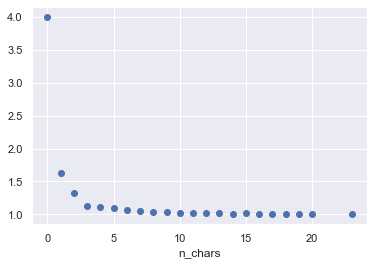

In [117]:
VOCAB.groupby('n_chars').n_pos.mean()\
    .sort_values(ascending=False).plot(style='o');

In [118]:
VOCAB.query('n_chars == "0"')

,n,n_chars,p,s,i,h,max_pos,n_pos,cat_pos,stop
term_str,,,,,,,,,,
,2548,0,0.002363,423.239796,8.725331,0.020616,NN,4,"{'', NN, CC, NNS}",0


In [119]:
VOCAB[VOCAB.stop == True].sort_values('n_pos', ascending=False)[['n_pos','cat_pos']].head(20)

,n_pos,cat_pos
term_str,,
what,4,"{RB, NN, WP, IN}"
that,4,"{NN, DT, RB, IN}"
there,4,"{EX, NN, RB, NNS}"
i,3,"{NN, PRP, NNS}"
on,3,"{NN, IN, NNS}"
do,3,"{NNS, NN, VB}"
but,3,"{CC, NN, NNS}"
he,3,"{NN, PRP, NNS}"
up,3,"{NN, RB, IN}"


# Add Stems

In [120]:
from nltk.stem.porter import PorterStemmer
stemmer1 = PorterStemmer()
VOCAB['stem_porter'] = VOCAB.apply(lambda x: stemmer1.stem(x.name), 1)

from nltk.stem.snowball import SnowballStemmer
stemmer2 = SnowballStemmer("english")
VOCAB['stem_snowball'] = VOCAB.apply(lambda x: stemmer2.stem(x.name), 1)

from nltk.stem.lancaster import LancasterStemmer
stemmer3 = LancasterStemmer()
VOCAB['stem_lancaster'] = VOCAB.apply(lambda x: stemmer3.stem(x.name), 1)

In [121]:
VOCAB

,n,n_chars,p,s,i,h,max_pos,n_pos,cat_pos,stop,stem_porter,stem_snowball,stem_lancaster
term_str,,,,,,,,,,,,,
i,38398,1,3.560596e-02,2.808519e+01,4.811737,0.171327,PRP,3,"{NN, PRP, NNS}",1,i,i,i
you,37473,3,3.474822e-02,2.877845e+01,4.846917,0.168422,PRP,3,"{NN, PRP, NNS}",1,you,you,you
the,30526,3,2.830636e-02,3.532775e+01,5.142730,0.145572,DT,3,"{NN, DT, NNS}",1,the,the,the
to,25701,2,2.383220e-02,4.196004e+01,5.390944,0.128478,TO,3,"{TO, NN, NNS}",1,to,to,to
a,23299,1,2.160486e-02,4.628589e+01,5.532501,0.119529,DT,3,"{NN, DT, NNS}",1,a,a,a
...,...,...,...,...,...,...,...,...,...,...,...,...,...
fingernails,1,11,9.272868e-07,1.078415e+06,20.040481,0.000019,NNS,1,{NNS},0,fingernail,fingernail,fingernail
wavelength,1,10,9.272868e-07,1.078415e+06,20.040481,0.000019,NN,1,{NN},0,wavelength,wavelength,waveleng
sleek,1,5,9.272868e-07,1.078415e+06,20.040481,0.000019,NN,1,{NN},0,sleek,sleek,sleek


In [122]:
#stem with the most associated terms
VOCAB.stem_lancaster.value_counts()

man            24
fin            24
op             24
com            23
not            20
               ..
paradox         1
salt            1
chuk            1
memorabilia     1
                1
Name: stem_lancaster, Length: 14869, dtype: int64

In [123]:
VOCAB[VOCAB.stem_lancaster == 'fin']

,n,n_chars,p,s,i,h,max_pos,n_pos,cat_pos,stop,stem_porter,stem_snowball,stem_lancaster
term_str,,,,,,,,,,,,,
fine,1713,4,1.588442e-03,6.295476e+02,9.298172,0.014770,NN,1,{NN},0,fine,fine,fin
finally,213,7,1.975121e-04,5.062981e+03,12.305771,0.002431,RB,1,{RB},0,final,final,fin
finish,103,6,9.551054e-05,1.047005e+04,13.353981,0.001275,NN,1,{NN},0,finish,finish,fin
finished,79,8,7.325566e-05,1.365082e+04,13.736700,0.001006,VBN,1,{VBN},0,finish,finish,fin
final,74,5,6.861922e-05,1.457318e+04,13.831028,0.000949,JJ,1,{JJ},0,final,final,fin
finn,53,4,4.914620e-05,2.034745e+04,14.312561,0.000703,NN,1,{NN},0,finn,finn,fin
financial,29,9,2.689132e-05,3.718672e+04,15.182500,0.000408,JJ,1,{JJ},0,financi,financi,fin
finals,26,6,2.410946e-05,4.147750e+04,15.340041,0.000370,NNS,1,{NNS},0,final,final,fin
finishing,18,9,1.669116e-05,5.991194e+04,15.870556,0.000265,VBG,1,{VBG},0,finish,finish,fin


In [126]:
VOCAB.head()

,n,n_chars,p,s,i,h,max_pos,n_pos,cat_pos,stop,stem_porter,stem_snowball,stem_lancaster
term_str,,,,,,,,,,,,,
i,38398,1,0.035606,28.085187,4.811737,0.171327,PRP,3,"{NN, PRP, NNS}",1,i,i,i
you,37473,3,0.034748,28.778454,4.846917,0.168422,PRP,3,"{NN, PRP, NNS}",1,you,you,you
the,30526,3,0.028306,35.327753,5.142730,0.145572,DT,3,"{NN, DT, NNS}",1,the,the,the
to,25701,2,0.023832,41.960040,5.390944,0.128478,TO,3,"{TO, NN, NNS}",1,to,to,to
a,23299,1,0.021605,46.285892,5.532501,0.119529,DT,3,"{NN, DT, NNS}",1,a,a,a


In [127]:
TOKENS.head()

pos_tuple pos  \
Season Episode Character line_num sent_num token_num                     
01     01      LORELAI   0        0        0          (Please, VB)  VB   
                                  1        0            (Luke, NN)  NN   
                         1        0        0          (Please, VB)  VB   
                                  1        0          (please, NN)  NN   
                                  2        0          (please, NN)  NN   

                                                     token_str term_str  
Season Episode Character line_num sent_num token_num                     
01     01      LORELAI   0        0        0            Please   please  
                                  1        0              Luke     luke  
                         1        0        0            Please   please  
                                  1        0            please   please  
                                  2        0            please   please

## Gather POS Information

In [136]:
pos_info = f'{data_home}/misc/upenn_tagset.txt'
POS = pd.DataFrame([(line.split()[0], ' '.join(line.split()[1:])) 
                    for line in open(pos_info, 'r').readlines()])
POS.columns = ['pos_id', 'pos_def']
POS = POS.set_index('pos_id')
POS['pos_group'] = POS.apply(lambda x: x.name[:2], 1)

In [137]:
VOCAB['max_pos_group'] =  VOCAB.max_pos.apply(lambda x: x[:2])
TOKENS['pos_group'] = TOKENS.pos.apply(lambda x: x[:2])

In [138]:
VOCAB.head()

,n,n_chars,p,s,i,h,max_pos,n_pos,cat_pos,stop,stem_porter,stem_snowball,stem_lancaster,max_pos_group
term_str,,,,,,,,,,,,,,
i,38398,1,0.035606,28.085187,4.811737,0.171327,PRP,3,"{NN, PRP, NNS}",1,i,i,i,PR
you,37473,3,0.034748,28.778454,4.846917,0.168422,PRP,3,"{NN, PRP, NNS}",1,you,you,you,PR
the,30526,3,0.028306,35.327753,5.142730,0.145572,DT,3,"{NN, DT, NNS}",1,the,the,the,DT
to,25701,2,0.023832,41.960040,5.390944,0.128478,TO,3,"{TO, NN, NNS}",1,to,to,to,TO
a,23299,1,0.021605,46.285892,5.532501,0.119529,DT,3,"{NN, DT, NNS}",1,a,a,a,DT


In [139]:
TOKENS.head()

pos_tuple pos  \
Season Episode Character line_num sent_num token_num                     
01     01      LORELAI   0        0        0          (Please, VB)  VB   
                                  1        0            (Luke, NN)  NN   
                         1        0        0          (Please, VB)  VB   
                                  1        0          (please, NN)  NN   
                                  2        0          (please, NN)  NN   

                                                     token_str term_str  \
Season Episode Character line_num sent_num token_num                      
01     01      LORELAI   0        0        0            Please   please   
                                  1        0              Luke     luke   
                         1        0        0            Please   please   
                                  1        0            please   please   
                                  2        0            please   please   

                                                     pos_group  
Season Episode Character line_num sent_num token_num            
01     01      LORELAI   0        0        0                VB  
                                  1        0                NN  
                         1        0        0                VB  
                                  1        0                NN  
                                  2        0                NN

In [140]:
#save output
#VOCAB.to_csv(f'{data_home}/output/{data_prefix}-VOCAB2.csv')
#TOKENS.to_csv(f'{data_home}/output/{data_prefix}-CORPUS2.csv')